<a href="https://colab.research.google.com/github/Dwarika1986/Pnemonia_detecition/blob/main/M2_Pneumonia_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CAPSTONE PROJECT - PNEUMONIA DETECTION CHALLENGE
## Milestone 2

**Course:** PGP-AIML, Great Learning

In [ ]:
path = '/content/drive/MyDrive/GL_Pneumonia_Detection/file/'

## Getting started

**Importing required libraries**

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import cv2
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing Deep learning libraries**

In [ ]:
# Importing required deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras import metrics

**Setting up the GPU**

In [ ]:
# Getting info on GPU
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.18.0
Num GPUs Available:  1


## Importing the Preprocessed Datasets

**Extracting the processed images**

In [ ]:
!unzip /content/drive/MyDrive/GL_Pneumonia_Detection/file/processed_images.zip
!mv /content/content/processed_images /content/processed_images/

**Importing required files**

In [ ]:
path = '/content/drive/MyDrive/GL_Pneumonia_Detection/file/'

# importing pickle
with open(path + 'processed_data.pkl', 'rb') as f:
    data = pickle.load(f)

# Importing essential data
X_train_ids, X_val_ids, X_test_ids = data['X_train_ids'], data['X_val_ids'], data['X_test_ids']
binary_target, multiclass_target = data['binary_target'], data['multiclass_target']
resized_bbox = data['resized_mask']

# importing Training, testing and validation sets
data_label = pd.read_csv(path + 'data_labels_xywh.csv')

**Custom Dataset Loader with Data Augmentation**

In [ ]:
import tensorflow as tf

new_dir = '/content/processed_images/'

# Data augmentation for training dataset only
data_augmentation = tf.keras.Sequential([

    # Adding augmentation other than roation is reducing model performance
    tf.keras.layers.RandomRotation(0.2),

])

def load_image_and_labels(filename, augment=False):
    """Load and preprocess an image, bounding box, and binary label, with optional augmentation."""

    def process_filename(filename):
        """Helper function to process filename and fetch labels."""
        filename_str = filename.numpy().decode("utf-8")  # Convert from bytes to string
        img_path = f"{new_dir}{filename_str}.jpg"

        # Read and decode image
        image = tf.io.read_file(img_path)
        image = tf.image.decode_jpeg(image, channels=1)
        image = tf.cast(image, tf.float32) #/ 255.0  # Normalize

        # Get binary label
        binary_label = binary_target[filename_str]  # Ensure binary_target is a dictionary
        binary_label = tf.convert_to_tensor(binary_label, dtype=tf.float32)

        return image, binary_label

    # Use tf.py_function to handle numpy() calls inside tf.data pipeline
    image, binary_label = tf.py_function(func=process_filename, inp=[filename], Tout=[tf.float32, tf.float32])

    # Fix Tensor shapes after tf.py_function
    image.set_shape((None, None, 1))  # Assuming grayscale image
    binary_label.set_shape(())

    if augment:
        image = data_augmentation(tf.expand_dims(image, 0))  # Add batch dimension
        image = tf.squeeze(image, axis=0)  # Remove batch dimension

    return image, binary_label

def create_dataset(file_ids, batch_size=32, shuffle=False, augment=False):
    """Create a TensorFlow dataset with optional augmentation."""
    dataset = tf.data.Dataset.from_tensor_slices(file_ids)

    # Load images and labels
    dataset = dataset.map(lambda x: load_image_and_labels(x, augment=augment), num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(file_ids))

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create training, validation, and test datasets
train_dataset = create_dataset(X_train_ids, batch_size=32, augment=True)
val_dataset = create_dataset(X_val_ids, batch_size=32)
test_dataset = create_dataset(X_test_ids, batch_size=32)

# collecting target variable
y_train = X_train_ids.apply(lambda x: binary_target[x])
y_test = X_test_ids.apply(lambda x: binary_target[x])

print('Dataset generated..')

Dataset generated..


**Functions for model Evaluation**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluating model - Traing Vs Test dataset
def model_eval(y_train, y_pred_train, y_test, y_pred_test, average = 'binary'):
  """ A function for evaluating model against Training and Testing scores """

  df_type = ['Train', 'Test']

  # calculating the scores
  col_acc = [accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)]
  col_pre = [precision_score(y_train, y_pred_train, average = average), precision_score(y_test, y_pred_test, average = average)]
  col_rec = [recall_score(y_train, y_pred_train, average = average), recall_score(y_test, y_pred_test, average = average)]
  col_f1s = [f1_score(y_train, y_pred_train, average = average), f1_score(y_test, y_pred_test, average = average)]

  # building the dataframe
  per_dict = {'Accuracy' : col_acc, 'Precision': col_pre, 'Recall': col_rec, 'F-score': col_f1s}
  per_df = pd.DataFrame(per_dict, index = df_type)

  return per_df


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

def conf_roc_info(y_train, y_prob_train, y_test, y_prob_test, figsize = (12,8)):
  """# A fucntion for plotting confusion matrix"""

  col = ['Predicted 0', 'Predicted 1']
  ind= ['Actual 0', 'Actual 1']

  # Training set
  y_pred_train = (y_prob_train > 0.5).astype(int)
  c_matrix_train = pd.DataFrame(confusion_matrix(y_train, y_pred_train), col, ind)
  fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_prob_train)
  roc_auc_train = auc(fpr_train, tpr_train)

  # Test set
  y_pred_test = (y_prob_test > 0.5).astype(int)
  c_matrix_test = pd.DataFrame(confusion_matrix(y_test, y_pred_test), col, ind)
  fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_prob_test)
  roc_auc_test = auc(fpr_test, tpr_test)

  # AUC Score
  auc_score_train = roc_auc_score(y_train, y_prob_train)
  auc_score_test = roc_auc_score(y_test, y_prob_test)

  fig, ax = plt.subplots(2,2, figsize = figsize)

  # plotting heatmap and roc curve for training set
  sns.heatmap(c_matrix_train, annot=True, fmt = 'g', ax = ax[0][0], cmap = 'Blues');
  ax[0][1].plot(fpr_train, tpr_train, 'r', label = 'AUC')
  ax[0][1].plot([0, 1], [0, 1],'r--')
  ax[0][0].set_title('Confusion Matrix: Training set')
  ax[0][1].set_title('Training set - AUC score: %.3f' % auc_score_train)

  # plotting heatmap and roc curve for test set
  sns.heatmap(c_matrix_test, annot=True, fmt = 'g', ax = ax[1][0], cmap = 'viridis');
  ax[1][1].plot(fpr_test, tpr_test, 'b', label = 'AUC')
  ax[1][1].plot([0, 1], [0, 1],'b--')
  ax[1][0].set_title('Confusion Matrix: Test set')
  ax[1][1].set_title('Test set - AUC score: %.3f' % auc_score_test)

  plt.show()

In [ ]:
# classification report
from sklearn.metrics import classification_report
def plot_classification_report(y, y_pred, color = 'Purples'):
  return pd.DataFrame(classification_report(y, y_pred, output_dict=True)).T.style.background_gradient(cmap=color)

##**Transfer Learning**

In [ ]:
#import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB0
import tensorflow.keras.optimizers as optimizers

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model initially
base_model.trainable = False

# Add custom layers
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=[metrics.Recall(name='Recall'),
             "accuracy",
             metrics.Precision(name='Precision'),
             metrics.AUC(name='AUC')]
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    class_weight={0: 1.0, 1: 3.0},
                    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/5
526/526 ━━━━━━━━━━━━━━━━━━━━ 128s 203ms/step - AUC: 0.7583 - Precision: 0.4254 - Recall: 0.6548 - accuracy: 0.7267 - loss: 0.8416 - val_AUC: 0.8254 - val_Precision: 0.4682 - val_Recall: 0.7530 - val_accuracy: 0.7516 - val_loss: 0.5060 - learning_rate: 1.0000e-04
Epoch 2/5
526/526 ━━━━━━━━━━━━━━━━━━━━ 81s 154ms/step - AUC: 0.8121 - Precision: 0.4586 - Recall: 0.7372 - accuracy: 0.7473 - loss: 0.7635 - val_AUC: 0.8312 - val_Precision: 0.4931 - val_Recall: 0.6770 - val_accuracy: 0.7703 - val_loss: 0.4517 - learning_rate: 1.0000e-04
Epoch 3/5
526/526 ━━━━━━━━━━━━━━━━━━━━ 79s 150ms/step - AUC: 0.8237 - Precision: 0.4624 - Recall: 0.7435 - accuracy: 0.7503 - loss: 0.7426 - val_AUC: 0.8366 - val_Precision: 0.4704 - val_Recall: 0.7743 - val_accuracy: 0.7527 - val_loss: 0.4885 - learning_rate: 1.0000e-04
Epoch 4/5
526/526 ━━━━━━━━━━━━━━━━━━━━ 82s 150ms/step - AUC: 0.8268 - Precision: 0.4662 - Recall: 0.7458 - accuracy: 0.7531 - loss: 0.7362 - val_AUC: 0.8376 - val_Precision: 0.4806 - 

In [ ]:
model.save_weights("efficientnet_pneumonia_transfer_learning.weights.h5")

In [ ]:
# train predictions
y_eff_transfer_train_prob = model.predict(train_dataset)
y_eff_transfer_train_pred = (y_eff_transfer_train_prob > 0.5).astype(int)

# test predictions
y_eff_transfer_test_prob = model.predict(test_dataset)
y_eff_transfer_test_pred = (y_eff_transfer_test_prob > 0.5).astype(int)

526/526 ━━━━━━━━━━━━━━━━━━━━ 84s 146ms/step
251/251 ━━━━━━━━━━━━━━━━━━━━ 24s 97ms/step


In [ ]:
eff_transfer_eval = model_eval(y_train, y_eff_transfer_train_pred, y_test, y_eff_transfer_test_pred)
eff_transfer_eval

,Accuracy,Precision,Recall,F-score
Train,0.764783,0.485219,0.723792,0.580967
Test,0.776168,0.502483,0.672949,0.575355


In [ ]:
# classification report - training set
plot_classification_report(y_train, y_eff_transfer_train_pred)

,precision,recall,f1-score,support
0,0.906281,0.776703,0.836503,13023.000000
1,0.485219,0.723792,0.580967,3787.000000
accuracy,0.764783,0.764783,0.764783,0.764783
macro avg,0.695750,0.750247,0.708735,16810.000000
weighted avg,0.811423,0.764783,0.778935,16810.000000


In [ ]:
# classification report - test set
plot_classification_report(y_test, y_eff_transfer_test_pred, color = 'Blues')

,precision,recall,f1-score,support
0,0.894454,0.806192,0.848033,6202.000000
1,0.502483,0.672949,0.575355,1804.000000
accuracy,0.776168,0.776168,0.776168,0.776168
macro avg,0.698469,0.739570,0.711694,8006.000000
weighted avg,0.806131,0.776168,0.786590,8006.000000


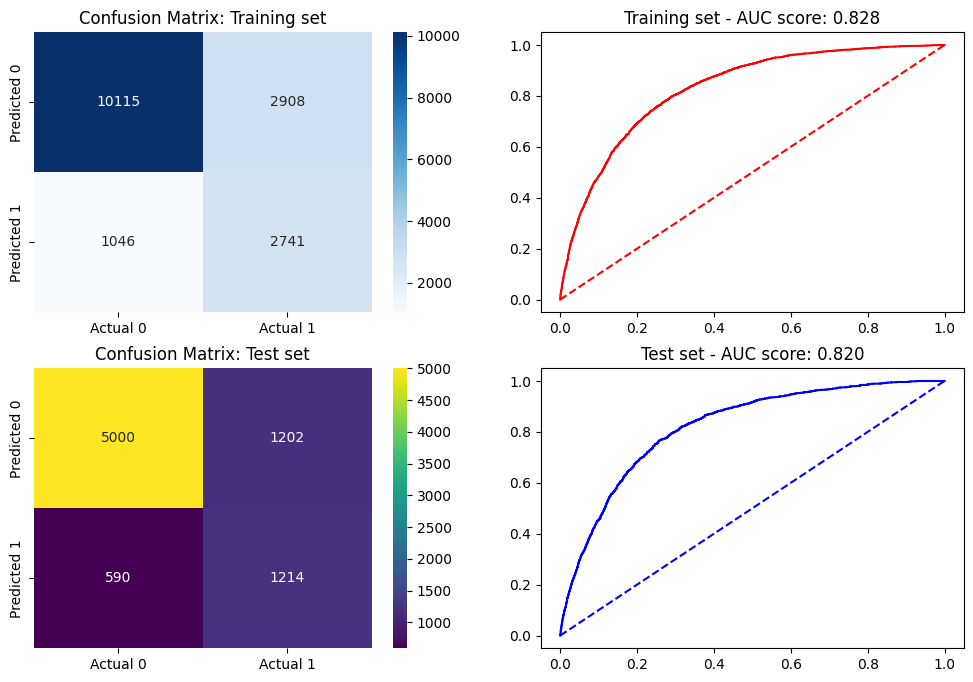

In [ ]:
conf_roc_info(y_train, y_eff_transfer_train_prob, y_test, y_eff_transfer_test_prob)

##**Fine Tuning**

In [ ]:
# Unfreeze the base model
base_model.trainable = True

# Recompile with a lower learning rate
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[metrics.Recall(name='Recall'),
             "accuracy",
             metrics.Precision(name='Precision'),
             metrics.AUC(name='AUC')]
)

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 4,335,741 (16.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_cnn_model.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

#Fine-tuning the model.
history_fine = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    class_weight={0: 1.0, 1: 3.0},
                    callbacks=[early_stopping, model_checkpoint, reduce_lr]
)

Epoch 1/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 293s 322ms/step - AUC: 0.7506 - Precision: 0.4037 - Recall: 0.6795 - accuracy: 0.7042 - loss: 0.8574 - val_AUC: 0.8219 - val_Precision: 0.4578 - val_Recall: 0.7482 - val_accuracy: 0.7436 - val_loss: 0.5132 - learning_rate: 1.0000e-05
Epoch 2/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 172s 228ms/step - AUC: 0.8163 - Precision: 0.4546 - Recall: 0.7400 - accuracy: 0.7445 - loss: 0.7553 - val_AUC: 0.8430 - val_Precision: 0.4992 - val_Recall: 0.7173 - val_accuracy: 0.7741 - val_loss: 0.4427 - learning_rate: 1.0000e-05
Epoch 3/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 120s 228ms/step - AUC: 0.8336 - Precision: 0.4700 - Recall: 0.7647 - accuracy: 0.7555 - loss: 0.7232 - val_AUC: 0.8517 - val_Precision: 0.5316 - val_Recall: 0.6983 - val_accuracy: 0.7934 - val_loss: 0.4217 - learning_rate: 1.0000e-05
Epoch 4/50
526/526 ━━━━━━━━━━━━━━━━━━━━ 144s 232ms/step - AUC: 0.8420 - Precision: 0.4703 - Recall: 0.7654 - accuracy: 0.7557 - loss: 0.7069 - val_AUC: 0.8561 - val_Precision: 0.

In [ ]:
model.save_weights("efficientnet_penumonia_fine_tuning.weights.h5")

In [ ]:
# train predictions
y_eff_fine_train_prob = model.predict(train_dataset)
y_eff_fine_train_pred = (y_eff_fine_train_prob > 0.5).astype(int)

# test predictions
y_eff_fine_test_prob = model.predict(test_dataset)
y_eff_fine_test_pred = (y_eff_fine_test_prob > 0.5).astype(int)

526/526 ━━━━━━━━━━━━━━━━━━━━ 90s 157ms/step
251/251 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step


In [ ]:
eff_fine_eval = model_eval(y_train, y_eff_fine_train_pred, y_test, y_eff_fine_test_pred)
eff_fine_eval

,Accuracy,Precision,Recall,F-score
Train,0.786199,0.516437,0.800634,0.627873
Test,0.814764,0.578331,0.656874,0.615105


In [ ]:
# classification report - training set
plot_classification_report(y_train, y_eff_fine_train_pred)

,precision,recall,f1-score,support
0,0.930981,0.782001,0.850013,13023.000000
1,0.516437,0.800634,0.627873,3787.000000
accuracy,0.786199,0.786199,0.786199,0.786199
macro avg,0.723709,0.791317,0.738943,16810.000000
weighted avg,0.837591,0.786199,0.799968,16810.000000


In [ ]:
# classification report - test set
plot_classification_report(y_test, y_eff_fine_test_pred, color = 'Blues')

,precision,recall,f1-score,support
0,0.896089,0.860690,0.878033,6202.000000
1,0.578331,0.656874,0.615105,1804.000000
accuracy,0.814764,0.814764,0.814764,0.814764
macro avg,0.737210,0.758782,0.746569,8006.000000
weighted avg,0.824488,0.814764,0.818787,8006.000000


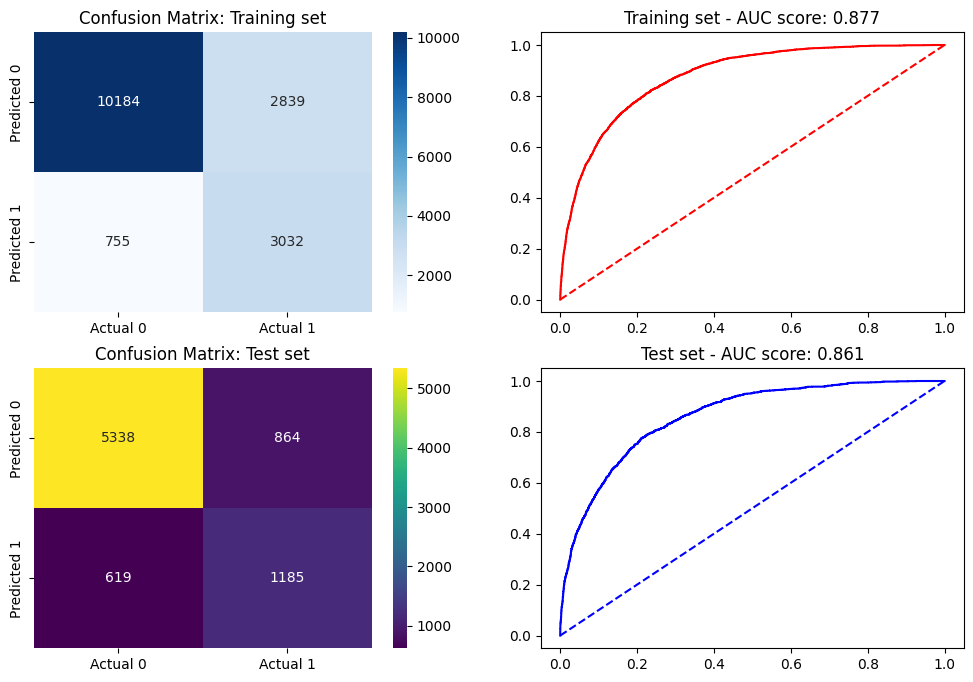

In [ ]:
conf_roc_info(y_train, y_eff_fine_train_prob, y_test, y_eff_fine_test_prob)

# Building R-CNN models and it's hybrids

In [ ]:
import torch
print('Cuda avilable:', torch.cuda.is_available())
print('GPUs available:"', torch.cuda.device_count())
print('Device Name:',torch.cuda.get_device_name(0))

Cuda avilable: True
GPUs available:" 1
Device Name: Tesla T4


In [ ]:
!nvidia-smi

Sat Mar 22 07:10:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   72C    P0             32W /   70W |    4276MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

**R-CNN**

In [ ]:
# selective search for region proposals
def selective_search_regions(path):
  """ function for extracting selective search regions"""
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
  ss.setBaseImage(img)
  ss.switchToSelectiveSearchFast()
  rects = ss.process()
  return rects

In [ ]:
path = '/content/processed_images/'

# load the input image
id = data_label['patientId'][6]
image_path = path+id+'.jpg'
rects = selective_search_regions(image_path)
image = cv2.imread(image_path)

# Plot image with bounding boxes
bbox_img = image.copy()
for (x, y, w, h) in rects:
    _color = (0, 0, random.randint(200, 255))
    cv2.rectangle(bbox_img, (x, y), (x + w, y + h), _color, 1)

gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
fig, ax = plt.subplots(1, 2, figsize=(14,9))
ax[0].imshow(gray_image, cmap=plt.cm.bone)
#ax[0].text(10,-10, "id : " + id, fontsize=6)
ax[0].set_title('Original Image')
ax[1].imshow(bbox_img)
ax[1].set_title('Selective Search proposals')
plt.show()

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from skimage.transform import resize
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from scipy.special import softmax

class Rcnn:
    def __init__(self):
        self.base_model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')
        self.feature_extractor = Model(inputs=self.base_model.input, outputs=self.base_model.output)
        self.svm = SVC(kernel='linear', probability=True)
        self.bbox_regressor = LinearRegression()

    def get_region_proposals(self, image):
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        ss.setBaseImage(image)
        ss.switchToSelectiveSearchFast()
        rects = ss.process()
        candidates = set()
        for (x, y, w, h) in rects:
            if w * h < 2000:  # Filter small regions
                continue
            candidates.add((x, y, w, h))
        return list(candidates)

    def extract_features(self, image, regions):
        features = []
        for (x, y, w, h) in regions:
            roi = image[y:y+h, x:x+w]
            roi_resized = resize(roi, (224, 224), anti_aliasing=True)  # Resize to model input size
            roi_resized = np.expand_dims(roi_resized, axis=0)  # Add batch dimension
            feature = self.feature_extractor.predict(roi_resized)
            features.append(feature.flatten())
        return np.array(features)

    def train(self, dataset):
        X_train, y_train, bbox_train = [], [], []
        for image_path, bbox, label in dataset:
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            regions = self.get_region_proposals(image)
            features = self.extract_features(image, regions)
            X_train.extend(features)
            y_train.extend([label] * len(features))
            bbox_train.extend([bbox] * len(features))

        self.svm.fit(X_train, y_train)
        self.bbox_regressor.fit(X_train, bbox_train)

    def predict(self, image, confidence_threshold=0.5, iou_threshold=0.3):
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        regions = self.get_region_proposals(image)
        features = self.extract_features(image, regions)
        probabilities = self.svm.predict_proba(features)[:, 1]  # Probability of pneumonia class
        refined_bboxes = self.bbox_regressor.predict(features)  # Predict refined bounding boxes

        # Convert bounding boxes to TensorFlow format
        refined_bboxes = np.array(refined_bboxes, dtype=np.float32)
        probabilities = np.array(probabilities, dtype=np.float32)

        # Apply confidence threshold
        high_confidence_indices = np.where(probabilities >= confidence_threshold)[0]
        selected_boxes = refined_bboxes[high_confidence_indices]
        selected_scores = probabilities[high_confidence_indices]

        if len(selected_boxes) == 0:
            return [], []

        # Apply Non-Maximum Suppression (NMS) using TensorFlow
        selected_indices = tf.image.non_max_suppression(
            boxes=selected_boxes,
            scores=selected_scores,
            max_output_size=len(selected_boxes),
            iou_threshold=iou_threshold
        ).numpy()

        final_boxes = selected_boxes[selected_indices]
        final_scores = selected_scores[selected_indices]

        return final_boxes.tolist(), final_scores.tolist()

rcnn_detector = Rcnn()
# rcnn_detector.train(dataset)  # Train with dataset

test_image = cv2.imread("test_image.jpg")
pred_bboxes, pred_scores = rcnn_detector.predict(test_image)

**Custom Dataloader class**

In [ ]:
import os
import cv2
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import json

# Define dataset class
class RSNADataset(Dataset):
    def __init__(self, image_ids, image_dir, bbox_dict, transforms=None):
        self.image_ids = image_ids  # List of patient IDs
        self.image_dir = image_dir  # Path to images
        self.bbox_dict = bbox_dict  # Dictionary with bounding boxes
        self.transforms = transforms

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        patient_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, f"{patient_id}.jpg")
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

        bboxes = []
        labels = []
        if patient_id in self.bbox_dict and len(self.bbox_dict[patient_id]) > 0:
            for bbox in self.bbox_dict[patient_id]:
                x1, y1, x2, y2 = bbox  # xyxy format
                bboxes.append([x1, y1, x2, y2])
                labels.append(1)  # Pneumonia label

        if self.transforms:
            augmented = self.transforms(image=image, bboxes=bboxes, labels=labels)
            image = augmented['image']
            bboxes = augmented['bboxes']
            labels = augmented['labels']

        # Convert to tensors
        image = image.clone().detach().to(torch.float32) if isinstance(image, torch.Tensor) else torch.from_numpy(image).to(torch.float32).permute(2, 0, 1)
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32) if bboxes else torch.zeros((0, 4), dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros((0,), dtype=torch.int64)

        target = {
            'boxes': bboxes,
            'labels': labels
        }
        return image, target

# Define data paths
image_dir = '/content/processed_images'

# Define data transformations
transform = A.Compose([
    A.Rotate(limit=10, p=0.5),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))  # FIXED: label_fields added

# Check if dataset variables are defined
try:
    dataset_train = RSNADataset(X_train_ids, image_dir, resized_bbox, transforms=transform)
    dataset_val = RSNADataset(X_val_ids, image_dir, resized_bbox, transforms=transform)
    dataset_test = RSNADataset(X_test_ids, image_dir, resized_bbox, transforms=transform)
except NameError as e:
    print(f"Dataset variable not defined: {e}")

# Custom collate function for DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

# Create dataloaders
dataloader_train = DataLoader(dataset_train, batch_size=2, shuffle=True, collate_fn=collate_fn)
dataloader_val = DataLoader(dataset_val, batch_size=2, shuffle=False, collate_fn=collate_fn)
dataloader_test = DataLoader(dataset_test, batch_size=2, shuffle=False, collate_fn=collate_fn)

**Custom Training and Validation Functions**

In [ ]:
from tqdm import tqdm
# Training and validation functions
def train_one_epoch(model, dataloader, optimizer):
    model.train()
    total_loss = 0
    for images, targets in tqdm(dataloader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    return total_loss / len(dataloader)

# Validation function
def validate(model, dataloader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()
    return total_loss / len(dataloader)

from torchvision.ops import box_iou

# Evaluation function
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    all_iou = []
    correct, total = 0, 0
    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].cpu()
                true_boxes = targets[i]['boxes'].cpu()
                if len(pred_boxes) > 0 and len(true_boxes) > 0:
                    ious = box_iou(pred_boxes, true_boxes)
                    max_iou, _ = torch.max(ious, dim=1)
                    all_iou.extend(max_iou.tolist())
                    correct += (max_iou > 0.5).sum().item()
                    total += len(true_boxes)

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()

    avg_iou = sum(all_iou) / len(all_iou) if all_iou else 0
    mAP = correct / total if total > 0 else 0
    return total_loss / len(dataloader), avg_iou, mAP

## Faster R-CNN model

In [ ]:
# Define the Faster R-CNN model
model_faster_rcnn = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
num_classes = 2

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_faster_rcnn.to(device)
optimizer_faster_rcnn = torch.optim.Adam(model_faster_rcnn.parameters(), lr=0.0001)

# Train Faster R-CNN for a few epochs
num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss_faster_rcnn = train_one_epoch(model_faster_rcnn, dataloader_train, optimizer_faster_rcnn)
    val_loss_faster_rcnn = validate(model_faster_rcnn, dataloader_val)


    print(f"Faster R-CNN -> Train Loss: {train_loss_faster_rcnn:.4f}, Val Loss: {val_loss_faster_rcnn:.4f}")
print("Training completed!")

Epoch 1/10
100%|██████████| 1084/1084 [35.34<18.11, 2.52it/s]
Faster R-CNN -> Train Loss: 0.88 Validation Loss: 0.93

Epoch 2/10
100%|██████████| 1084/1084 [35.56<18.32, 2.02it/s]
Faster R-CNN -> Train Loss: 0.87 Validation Loss: 0.92

Epoch 3/10
100%|██████████| 1084/1084 [35.34<18.66, 2.33it/s]
Faster R-CNN -> Train Loss: 0.85 Validation Loss: 0.91

Epoch 4/10
100%|██████████| 1084/1084 [35.79<18.28, 2.63it/s]
Faster R-CNN -> Train Loss: 0.83 Validation Loss: 0.89

Epoch 5/10
100%|██████████| 1084/1084 [35.92<18.66, 2.49it/s]
Faster R-CNN -> Train Loss: 0.8 Validation Loss: 0.88

Epoch 6/10
100%|██████████| 1084/1084 [36.36<18.34, 2.84it/s]
Faster R-CNN -> Train Loss: 0.78 Validation Loss: 0.87

Epoch 7/10
100%|██████████| 1084/1084 [36.3<18.66, 2.95it/s]
Faster R-CNN -> Train Loss: 0.75 Validation Loss: 0.86

Epoch 8/10
100%|██████████| 1084/1084 [35.82<18.89, 2.39it/s]
Faster R-CNN -> Train Loss: 0.72 Validation Loss: 0.85

Epoch 9/10
100%|██████████| 1084/1084 [35.65<18.44, 2.53it

In [ ]:
# Evaluate Faster R-CNN on test set
test_loss, test_iou, test_map = evaluate(model_faster_rcnn, dataloader_test)
print(f"Faster R-CNN Test Loss: {test_loss:.4f}")
print(f"Faster R-CNN Average IoU: {test_iou:.4f}")
print(f"Faster R-CNN mAP: {test_map:.4f}")

Faster R-CNN Test Loss: 0.72
Faster R-CNN Average IoU: 0.43
Faster R-CNN mAP: 0.32


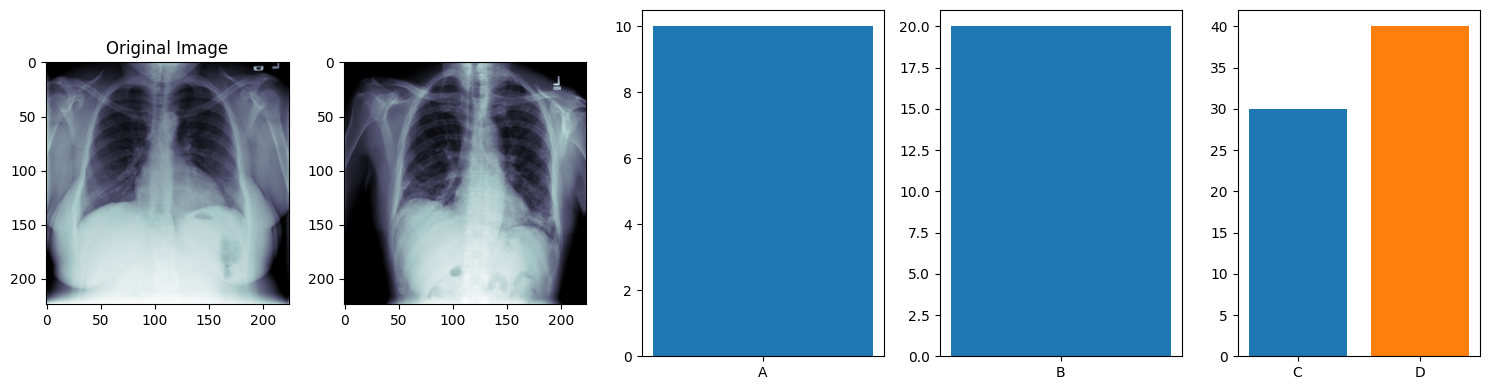

In [ ]:
from PIL import Image
fig, ax = plt.subplots(1, 5, figsize=(15,4))

image_path = '/content/processed_images/043cf55e-48db-407e-b8a3-e4b2d45a3131.jpg'
image_path2 = '/content/processed_images/0444a527-72cf-4bc9-b17f-100cf7acc889.jpg'
img = Image.open(image_path)
ax[0].imshow(img, cmap='bone')
ax[0].set_title("Original Image")
img2 = Image.open(image_path2)
ax[1].imshow(img2, cmap = 'bone')
ax[2].bar(["A"], [10], width = 0.2)
ax[3].bar( ["B"], [20], width = 0.2)
ax[4].bar( ["C"],[30])
ax[4].bar( ["D"],[40])

plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(10,9))
v = 15
# for two rows
for i in [0, 1]:
  n = 0
  # for 3 samples
  for id in data_labels['patientId'][v:v+3]:
    # plotting the bounding boxes
    plot_bounding_boxes(id, ax[i,n])
    ax[i,n].text(10, -190, "id : " + id, fontsize=6)
    ax[i,n].text(10, -120, "Class : " + class_info[class_info['patientId'] == id].reset_index()['class'][0], fontsize=10)
    ax[i,n].text(10, -50, "Target : " + str(train_labels[train_labels['patientId'] == id].reset_index()['Target'][0]), fontsize=10)
    n+=1
  v+=3
# removing x and y ticks
for ax in ax.flat:
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()



In [ ]:
#save model_faster_rcnn as pickle
import pickle

with open('model_faster_rcnn.pkl', 'wb') as f:
    pickle.dump(model_faster_rcnn, f)

## Mask R-CNN model

In [ ]:
# Define the Mask R-CNN model
model_mask_rcnn = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mask_rcnn.to(device)
optimizer_mask_rcnn = torch.optim.Adam(model_mask_rcnn.parameters(), lr=0.0001)

# Train Faster R-CNN and Mask R-CNN for a few epochs
num_epochs = 10
for epoch in range(num_epochs):

    print(f"Epoch {epoch+1}/{num_epochs}")
    train_loss_mask_rcnn = train_one_epoch(model_mask_rcnn, dataloader_train, optimizer_mask_rcnn)
    val_loss_mask_rcnn = validate(model_mask_rcnn, dataloader_val)
    print(f"Mask R-CNN -> Train Loss: {train_loss_mask_rcnn:.4f}, Val Loss: {val_loss_mask_rcnn:.4f}")

print("Training completed!")

Epoch 1/10
100%|██████████| 1084/1084 [36.13<18.63, 2.42it/s]
Faster R-CNN -> Train Loss: 0.81 Validation Loss: 0.92

Epoch 2/10
100%|██████████| 1084/1084 [35.66<18.52, 2.72it/s]
Faster R-CNN -> Train Loss: 0.73 Validation Loss: 0.83

Epoch 3/10
100%|██████████| 1084/1084 [35.65<18.23, 2.83it/s]
Faster R-CNN -> Train Loss: 0.67 Validation Loss: 0.81

Epoch 4/10
100%|██████████| 1084/1084 [36.2<18.71, 2.35it/s]
Faster R-CNN -> Train Loss: 0.58 Validation Loss: 0.76

Epoch 5/10
100%|██████████| 1084/1084 [35.57<18.96, 2.5it/s]
Faster R-CNN -> Train Loss: 0.51 Validation Loss: 0.74

Epoch 6/10
100%|██████████| 1084/1084 [35.32<18.57, 2.55it/s]
Faster R-CNN -> Train Loss: 0.47 Validation Loss: 0.68

Epoch 7/10
100%|██████████| 1084/1084 [35.82<18.43, 2.22it/s]
Faster R-CNN -> Train Loss: 0.4 Validation Loss: 0.67

Epoch 8/10
100%|██████████| 1084/1084 [35.57<18.18, 2.09it/s]
Faster R-CNN -> Train Loss: 0.33 Validation Loss: 0.64

Epoch 9/10
100%|██████████| 1084/1084 [35.33<19.03, 2.81it/

In [ ]:
# Evaluate Mask R-CNN on test set
test_loss, test_iou, test_map = evaluate(model_mask_rcnn, dataloader_test)
print(f"Mask R-CNN Test Loss: {test_loss:.4f}")
print(f"Mask R-CNN Average IoU: {test_iou:.4f}")
print(f"Mask R-CNN mAP: {test_map:.4f}")

Mask R-CNN Test Loss: 0.49
Mask R-CNN Average IoU: 0.54
Mask R-CNN mAP: 0.36


In [ ]:
# save mask r-cnn as pickle
import pickle

with open('model_mask_rcnn.pkl', 'wb') as f:
    pickle.dump(model_mask_rcnn, f)

## YOLO model

In [ ]:
# install ultralytics
!pip install ultralytics

In [ ]:
import os

train_dir = '/content/train/images/'
val_dir = '/content/val/images/'
test_dir = '/content/test/images/'

train_labels_dir = '/content/train/labels/'
val_labels_dir = '/content/val/labels/'
test_labels_dir = '/content/test/labels/'

for dir in [train_dir, val_dir, test_dir,
            train_labels_dir, val_labels_dir, test_labels_dir]:
            os.makedirs(dir, exist_ok=True)

In [ ]:
# converting xyxy to yolo annotation format
def convert_xyxy_to_yolo(bbox_xyxy, image_width = 224, image_height = 224):
    x1, y1, x2, y2 = bbox_xyxy
    x_center = (x1 + x2) / 2 / image_width
    y_center = (y1 + y2) / 2 / image_height
    width = (x2 - x1) / image_width
    height = (y2 - y1) / image_height
    return f"0 {x_center} {y_center} {width} {height}"

# generating annotation file
def generate_yolo_annotation(image_id, annotations, target_dir):
    """  Generates a YOLO annotation text file for a given image. """
    annotation_file_path = os.path.join(target_dir, f"{image_id}.txt")
    with open(annotation_file_path, "w") as f:
        for bbox in annotations:
            yolo_bbox = convert_xyxy_to_yolo(bbox)
            f.write(yolo_bbox + "\n")

In [ ]:
import shutil
from tqdm import tqdm

# placing stuff
def copy_images(patient_ids, source_dir, target_dir, target_label_dir):

    # Create the target directory if it doesn't exist
    os.makedirs(target_dir, exist_ok=True)

    for image_id in tqdm(patient_ids):
        source_path = os.path.join(source_dir, f"{image_id}.jpg")
        target_path = os.path.join(target_dir, f"{image_id}.jpg")

        if os.path.exists(source_path):
            shutil.copy(source_path, target_path)
        else:
            print("Image not found: {source_path}")

        # yolo annotation file
        generate_yolo_annotation(image_id, resized_bbox[image_id], target_label_dir)

original_dir = '/content/processed_images/'

# Training images
print('Training images..')
copy_images(X_train_ids, original_dir, train_dir, train_labels_dir)

# Validation images
print('Validation images..')
copy_images(X_val_ids, original_dir, val_dir, val_labels_dir)

# Test images
print('Test images..')
copy_images(X_test_ids, original_dir, test_dir, test_labels_dir)

Training images..


100%|██████████| 16810/16810 [00:07<00:00, 2331.45it/s]


Validation images..


100%|██████████| 1868/1868 [00:00<00:00, 5656.78it/s]


Test images..


100%|██████████| 8006/8006 [00:01<00:00, 4059.69it/s]


In [ ]:
import yaml

# Create data.yaml for YOLO
data_yaml = {
    "train": train_dir,
    "val": val_dir,
    "nc": 1,  # only one class (pneumonia)
    "names": ["pneumonia"],
}

with open('/content/data.yaml', "w") as f:
  yaml.dump(data_yaml, f)

In [ ]:
from ultralytics import YOLO

# Load YOLO model
yolo_model = YOLO("yolov8n.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 124MB/s]


In [ ]:
# training the yolo model
yolo_results = yolo_model.train(data='/content/data.yaml', epochs=50, batch=16, patience=8, imgsz = 224)

Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/data.yaml, epochs=50, time=None, patience=8, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, lin

100%|██████████| 755k/755k [00:00<00:00, 21.6MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 105MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 16810 images, 13023 backgrounds, 0 corrupt: 100%|██████████| 16810/16810 [00:04<00:00, 3542.56it/s]


train: New cache created: /content/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/val/labels... 1868 images, 1447 backgrounds, 0 corrupt: 100%|██████████| 1868/1868 [00:00<00:00, 2969.73it/s]

val: New cache created: /content/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50     0.348G      2.375      3.319       1.76          2        224: 100%|██████████| 1051/1051 [02:05<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:08<00:00,  7.01it/s]

                   all       1868        682      0.273     0.0997     0.0944     0.0338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50     0.367G      2.277      2.735      1.631          5        224: 100%|██████████| 1051/1051 [01:58<00:00,  8.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.10it/s]

                   all       1868        682     0.0587      0.113     0.0236    0.00594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50     0.389G      2.379      2.708      1.707         10        224: 100%|██████████| 1051/1051 [01:55<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 10.07it/s]


                   all       1868        682      0.221      0.312      0.168     0.0549

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50       0.4G      2.379      2.614      1.708         15        224: 100%|██████████| 1051/1051 [01:55<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  8.82it/s]


                   all       1868        682      0.204       0.28      0.167      0.053

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50       0.4G      2.316      2.505      1.683          3        224: 100%|██████████| 1051/1051 [01:55<00:00,  9.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 10.14it/s]

                   all       1868        682     0.0324      0.365      0.042     0.0128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      0.42G      2.249      2.465      1.646          5        224: 100%|██████████| 1051/1051 [01:56<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 10.03it/s]

                   all       1868        682      0.261      0.404      0.221     0.0712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      0.43G      2.226      2.361      1.619          2        224: 100%|██████████| 1051/1051 [01:54<00:00,  9.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  8.54it/s]

                   all       1868        682      0.393      0.318       0.29      0.102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50     0.441G        2.2      2.367      1.612          4        224: 100%|██████████| 1051/1051 [01:53<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.22it/s]


                   all       1868        682      0.226      0.487      0.213     0.0685

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50     0.445G      2.163      2.348      1.595          7        224: 100%|██████████| 1051/1051 [01:53<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00,  9.96it/s]

                   all       1868        682      0.375      0.403      0.324      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50     0.465G      2.156      2.295      1.567         11        224: 100%|██████████| 1051/1051 [01:53<00:00,  9.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.37it/s]

                   all       1868        682      0.337      0.353      0.268     0.0936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50     0.477G      2.136       2.29      1.554          8        224: 100%|██████████| 1051/1051 [01:54<00:00,  9.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 10.38it/s]


                   all       1868        682      0.422      0.386      0.336      0.126

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50     0.488G      2.098      2.283       1.55          7        224: 100%|██████████| 1051/1051 [01:54<00:00,  9.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.05it/s]

                   all       1868        682      0.444      0.311      0.305      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      0.49G      2.114      2.308      1.536          4        224: 100%|██████████| 1051/1051 [01:54<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 10.09it/s]

                   all       1868        682      0.387      0.349      0.325      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      0.51G        2.1       2.26      1.528          4        224: 100%|██████████| 1051/1051 [01:56<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  7.91it/s]


                   all       1868        682      0.422      0.365      0.321      0.123

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50     0.521G      2.078      2.255      1.528          5        224: 100%|██████████| 1051/1051 [01:55<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 10.09it/s]

                   all       1868        682      0.449      0.365      0.359      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50     0.533G      2.079      2.248       1.53          9        224: 100%|██████████| 1051/1051 [01:54<00:00,  9.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.16it/s]

                   all       1868        682      0.436      0.368      0.347      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50     0.535G      2.072      2.276      1.516          1        224: 100%|██████████| 1051/1051 [01:54<00:00,  9.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 10.35it/s]


                   all       1868        682      0.434      0.393      0.361      0.136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50     0.557G      2.067      2.237      1.517          4        224: 100%|██████████| 1051/1051 [01:53<00:00,  9.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  8.75it/s]

                   all       1868        682      0.435      0.375      0.356      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50     0.566G      2.053      2.215      1.517          7        224: 100%|██████████| 1051/1051 [01:53<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.07it/s]

                   all       1868        682      0.402      0.377      0.347      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50     0.578G      2.042      2.206      1.499          5        224: 100%|██████████| 1051/1051 [01:56<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.49it/s]

                   all       1868        682      0.439      0.371      0.351      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      0.58G      2.035      2.224      1.497          9        224: 100%|██████████| 1051/1051 [01:56<00:00,  9.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.54it/s]

                   all       1868        682      0.416       0.38      0.355      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50     0.602G       2.04      2.197      1.491          7        224: 100%|██████████| 1051/1051 [01:56<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  8.99it/s]

                   all       1868        682      0.439      0.383       0.37      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50     0.611G      2.042      2.186      1.491          3        224: 100%|██████████| 1051/1051 [01:54<00:00,  9.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.07it/s]

                   all       1868        682      0.434      0.397      0.372      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50     0.625G      2.028      2.172      1.495          8        224: 100%|██████████| 1051/1051 [01:54<00:00,  9.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 10.31it/s]

                   all       1868        682      0.422      0.387      0.358       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50     0.625G      2.016      2.158      1.487          3        224: 100%|██████████| 1051/1051 [01:55<00:00,  9.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  8.49it/s]

                   all       1868        682      0.452      0.384      0.361       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50     0.646G      2.004      2.183      1.482          8        224: 100%|██████████| 1051/1051 [01:56<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 10.57it/s]

                   all       1868        682      0.426      0.387      0.365      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50     0.658G      1.996      2.195      1.481          8        224: 100%|██████████| 1051/1051 [01:58<00:00,  8.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 10.07it/s]

                   all       1868        682      0.429      0.383      0.368      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      0.67G      1.986      2.185       1.46          4        224: 100%|██████████| 1051/1051 [01:56<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.82it/s]

                   all       1868        682      0.396      0.399      0.362       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      0.67G      1.997      2.179      1.468          4        224: 100%|██████████| 1051/1051 [01:56<00:00,  8.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.06it/s]

                   all       1868        682      0.456      0.403      0.374      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50     0.693G      1.989      2.142      1.466          3        224: 100%|██████████| 1051/1051 [01:55<00:00,  9.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.64it/s]

                   all       1868        682      0.428      0.403      0.355      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50     0.703G      1.983      2.132      1.463          3        224: 100%|██████████| 1051/1051 [01:56<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.26it/s]

                   all       1868        682      0.426      0.399      0.377      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50     0.715G      1.981       2.11      1.463         10        224: 100%|██████████| 1051/1051 [01:56<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.60it/s]

                   all       1868        682      0.425      0.408      0.378      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50     0.717G      1.968      2.139      1.465          7        224: 100%|██████████| 1051/1051 [01:56<00:00,  9.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.24it/s]

                   all       1868        682      0.458      0.406      0.379      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50     0.738G      1.941      2.091      1.449          6        224: 100%|██████████| 1051/1051 [01:56<00:00,  9.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.07it/s]

                   all       1868        682      0.443      0.419      0.384      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50     0.748G      1.952       2.11      1.448          8        224: 100%|██████████| 1051/1051 [01:56<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  9.76it/s]


                   all       1868        682      0.447        0.4      0.382      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      0.76G      1.952      2.131      1.442          1        224: 100%|██████████| 1051/1051 [01:55<00:00,  9.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:06<00:00,  8.79it/s]

                   all       1868        682       0.44      0.399      0.378      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50     0.762G      1.941      2.098      1.449          6        224: 100%|██████████| 1051/1051 [01:56<00:00,  9.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 10.37it/s]

                   all       1868        682      0.431      0.393       0.38      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50     0.783G      1.944       2.07      1.449          7        224: 100%|██████████| 1051/1051 [01:58<00:00,  8.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.04it/s]

                   all       1868        682      0.422        0.4       0.38      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50     0.795G      1.928      2.085       1.43          9        224: 100%|██████████| 1051/1051 [01:56<00:00,  9.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 10.52it/s]

                   all       1868        682      0.432       0.41       0.38      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50     0.805G      1.914      2.122      1.418          6        224: 100%|██████████| 1051/1051 [01:56<00:00,  9.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.19it/s]

                   all       1868        682      0.406      0.412      0.375      0.152


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50     0.807G      1.964      2.239       1.53          3        224: 100%|██████████| 1051/1051 [01:53<00:00,  9.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 10.22it/s]

                   all       1868        682      0.394      0.409      0.374      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50     0.828G       1.95      2.208       1.52          0        224: 100%|██████████| 1051/1051 [01:53<00:00,  9.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 10.61it/s]

                   all       1868        682      0.414      0.397       0.37      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      0.84G      1.945      2.202      1.515          2        224: 100%|██████████| 1051/1051 [01:52<00:00,  9.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:07<00:00,  8.31it/s]

                   all       1868        682      0.401      0.403      0.364      0.149


EarlyStopping: Training stopped early as no improvement observed in last 8 epochs. Best results observed at epoch 35, best model saved as best.pt.
To update EarlyStopping(patience=8) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

43 epochs completed in 1.463 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 59/59 [00:05<00:00, 10.53it/s]


                   all       1868        682      0.449        0.4      0.382      0.152
Speed: 0.0ms preprocess, 0.5ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


In [ ]:
# export yolo model
yolo_model.export(format='torch')

WARNING ⚠️ Invalid export format='torch', updating to format='torchscript'
Ultralytics 8.3.94 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'runs/detect/train/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 5, 1029) (5.9 MB)

TorchScript: starting export with torch 2.6.0+cu124...
TorchScript: export success ✅ 1.4s, saved as 'runs/detect/train/weights/best.torchscript' (11.8 MB)

Export complete (3.0s)
Results saved to /content/runs/detect/train/weights
Predict:         yolo predict task=detect model=runs/detect/train/weights/best.torchscript imgsz=224  
Validate:        yolo val task=detect model=runs/detect/train/weights/best.torchscript imgsz=224 data=/content/data.yaml  
Visualize:       https://netron.app


'runs/detect/train/weights/best.torchscript'

This will save the .pt file in the runs/detect/train/weights/ directory.

## Conclusion